In [162]:
import sklearn as skl
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pandas as pd
import sys
sys.path.append('/Users/kategroschner/Documents/pyNanoFind/utilities/')
import realDataProcess as rdp
from skimage import morphology as morph

In [2]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.losses import binary_crossentropy
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
pred = np.load('chiral_net_v1.npy')

In [4]:
def  dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Dropout(0.2)(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

def get_unet(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    down0, down0_res = down(4, inputs)
    down1, down1_res = down(8, down0)
    down2, down2_res = down(16, down1)
    down3, down3_res = down(32, down2)

    center = Conv2D(32, (3, 3), padding='same')(down3)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(32, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up3 = up(32, center, down3_res)
    up2 = up(16, up3, down2_res)
    up1 = up(8, up2, down1_res)
    up0 = up(4, up1, down0_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0)

    model = Model(inputs=inputs, outputs=classify)

    return model


In [5]:
model = get_unet((400,400,1),1)

In [6]:
model.load_weights('chiral_net_v1.h5')

In [7]:
images = h5py.File('chiral_image_stack.h5','r')['stack']
masks = h5py.File('chiral_mask_stack.h5')['masks']

In [8]:
pred_images = images[2000:2500]
pred_masks = masks[2000:2500]

In [9]:
pred_images = np.expand_dims(pred_images,axis =3)

In [10]:
predicted = model.predict(pred_images)

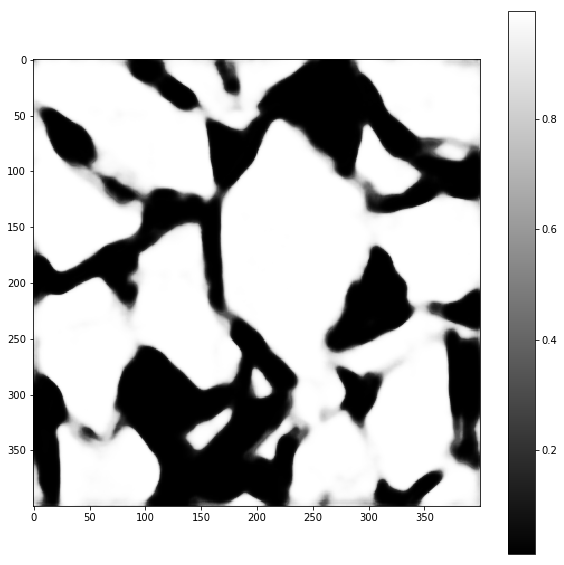

In [39]:
rdp.imm(predicted[0],(400,400))

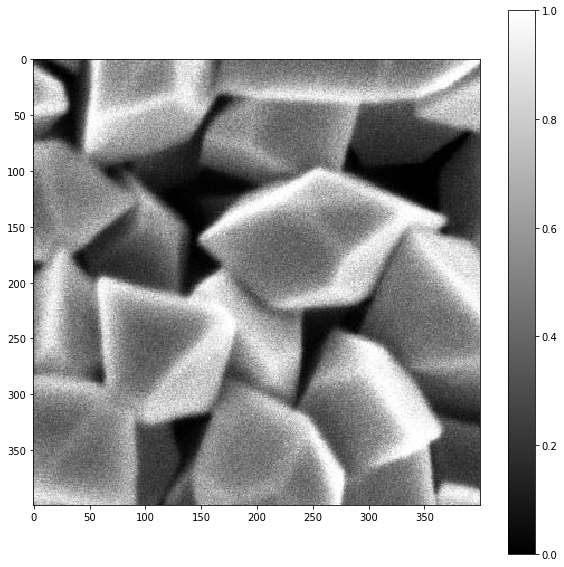

In [132]:
rdp.imm(pred_images[100,:,:,0],size=(400,400))

In [35]:
bin_thresh = predicted.copy()

In [36]:
bin_thresh[bin_thresh<0.9] = 0

In [45]:
bin_thresh[bin_thresh>= 0.9] = 1

In [129]:
bin_thresh.shape

(500, 400, 400, 1)

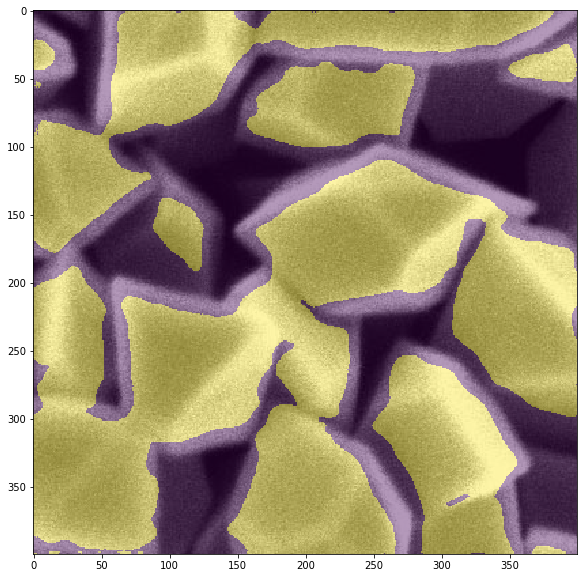

In [133]:
rdp.immOverlay(pred_images[:,:,:,0],bin_thresh[:,:,:,0],100)

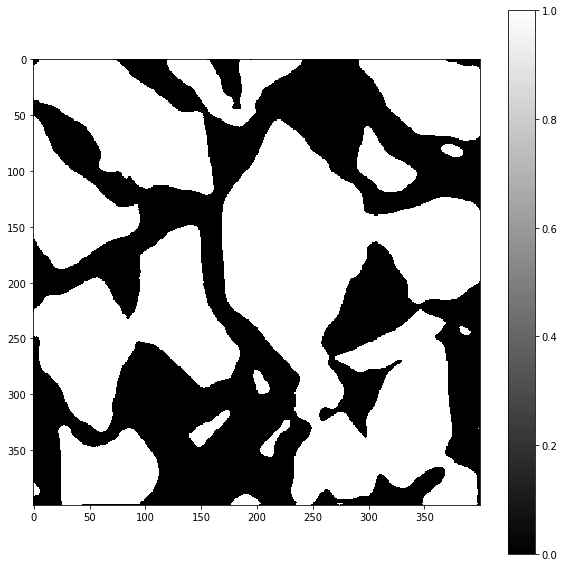

In [46]:
rdp.imm(bin_thresh[0],(400,400))

In [47]:
rdp.np_dice_coef(pred_masks.flatten(),bin_thresh.flatten())

0.94998584032464284

In [42]:
import segmentationAnalysis as sega

In [43]:
from sklearn import metrics

In [48]:
cfm = metrics.confusion_matrix(pred_masks.flatten(),bin_thresh.flatten())

In [50]:
def plot_confusion_matrix(cfm, Y_labels,save=False):
    """Creates a confusion matrix for the different classes given a true labels,predictions, the dataset
    and the desired trained classfier"""
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
    df_cfm = pd.DataFrame(data = cfm, columns=Y_labels, index=Y_labels)
    plt.subplots(figsize=(5,5))
    ax = sns.heatmap(df_cfm, annot=True,cmap='rainbow')
    ax.set(ylabel='True label',xlabel='Predicted label')
    if save == True:
        fname = input('Specify filename to save figure to: ')
        fig = ax.get_figure()
        fig.savefig(fname)

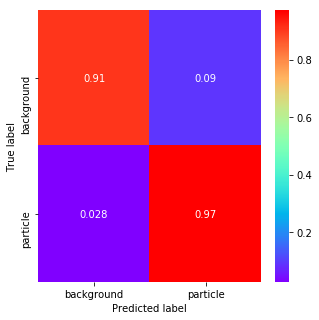

In [51]:
plot_confusion_matrix(cfm,['background','particle'])

In [52]:
from skimage import morphology as morph

In [53]:
a = bin_thresh.copy()

In [108]:
b = a[0,:,:,0]

In [109]:
b = morph.binary_erosion(morph.binary_erosion(b,morph.disk(10)),morph.disk(7))

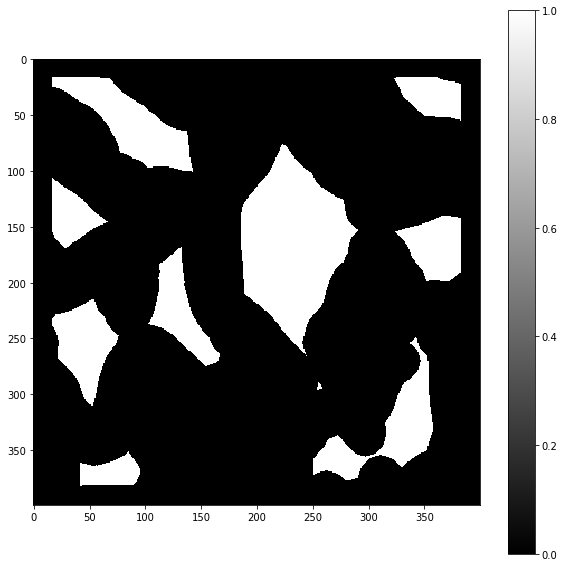

In [110]:
rdp.imm(b,(400,400))

In [80]:
from skimage import measure

In [104]:
l = measure.label(b,neighbors=8,connectivity=2)

In [87]:
from skimage import color

In [105]:
image_label_overlay = color.label2rgb(l, image=b)

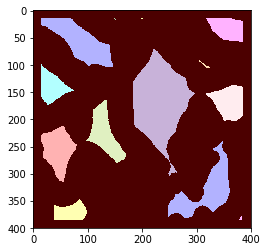

In [106]:
plt.imshow(image_label_overlay)

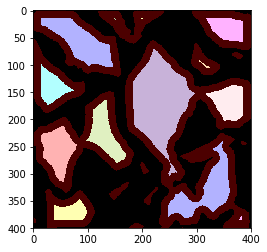

In [112]:
plt.imshow(image_label_overlay*bin_thresh[0])

In [118]:
q = measure.regionprops(l)

In [122]:
q[0].area

5545

In [123]:
for region in q:
    print(region.area)

5545
4
2254
3
12893
71
2289
3038
3513
3856
5476
1618
30


In [15]:
a = np.arange(15,17,0.5)

In [16]:
a

array([ 15. ,  15.5,  16. ,  16.5])

In [17]:
b=np.arange(0,4)

In [18]:
b

array([0, 1, 2, 3])

In [19]:
a = a.reshape((2,2))

In [20]:
a

array([[ 15. ,  15.5],
       [ 16. ,  16.5]])

In [27]:
x,y = np.unravel_index(b,(2,2),'C')

In [30]:
x.shape

(4,)

In [31]:
def make_tuple_idx(flat_idx,shape):
    x,y = np.unravel_index(flat_idx,shape)
    tuple_list = [(x[i],y[i]) for i in np.arange(0,len(x))]
    return tuple_list

In [32]:
t_l = make_tuple_idx(b,(2,2))

In [52]:
tl_pred = make_tuple_idx(np.arange(2000,2500),(64,64))

In [76]:
np.array(tl_pred)[:,0].max()

39

In [ ]:
t_l = make_tuple_idx(np.arange(0,500),(39,2))

In [78]:
a = tl_pred[0][0]*25+400

In [82]:
a = np.zeros((2,2))
b = np.ones((2,2))
a[:,1] += b[:,1]

In [83]:
a

array([[ 0.,  1.],
       [ 0.,  1.]])

In [ ]:
#from Demo2.ipynb
def slidding_window(image, mask, windowSize, step):
    numWindows = (image.shape[0]-windowSize)//step
    window_stack = []
    mask_stack = []
    for i in np.arange(0,numWindows):
        for j in np.arange(0,numWindows):
            window_stack.append(image[i*step:i*step+windowSize,j*step:j*step+windowSize])
            mask_stack.append(mask[i*step:i*step+windowSize,j*step:j*step+windowSize])
    window_stack = np.array(window_stack)
    mask_stack = np.array(mask_stack)
    return window_stack, mask_stack

In [106]:
a = np.arange(61,64)*25

In [107]:
a

array([1525, 1550, 1575])

In [145]:
def reassemble_masks(stack,original_size,start_idx,stop_idx, windowSize, step):
    numWindows = (original_size[0]-windowSize)//step
    recon = np.zeros(original_size)
    length_stack = stack.shape[0]
    indices = []
    for i in np.arange(0,numWindows):
        for j in np.arange(0,numWindows):
            indices.append([i*step,i*step+windowSize,j*step,j*step+windowSize])
    indices = indices[start_idx:stop_idx]
    for idx, img in enumerate(stack):
        loc = indices[idx]
        i = img[:,:,0]
        i[i>0.9] = 1
        i[i<1] = 0
        recon[loc[0]:loc[1],loc[2]:loc[3]] += i
    return recon

In [146]:
recon3 = reassemble_masks(predicted,(2000,2000),2000,2500,400,25)

In [115]:
recon.shape

(2000, 2000)

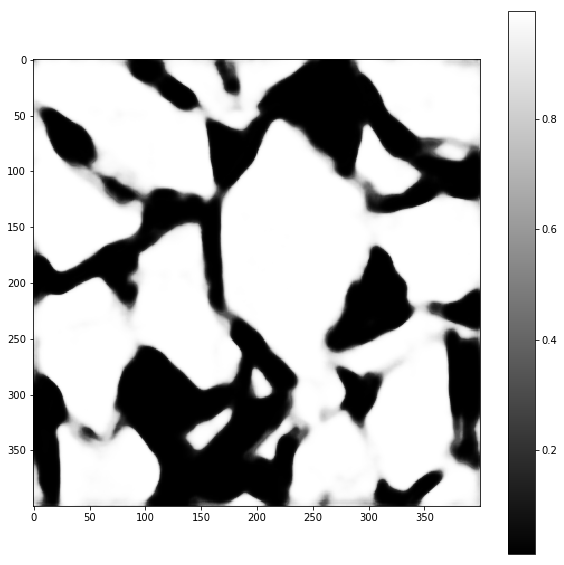

In [120]:
rdp.imm(predicted[0],(400,400))

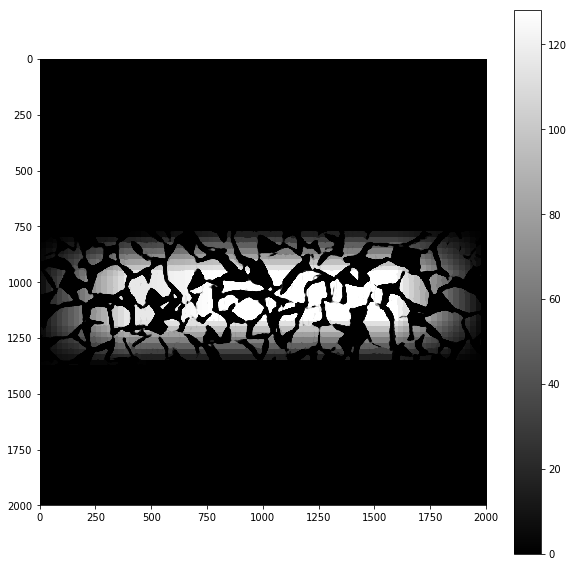

In [148]:
rdp.imm(recon3,(2000,2000))

In [136]:
recon2 = recon.copy()

In [151]:
recon3[recon3<1] = 0

In [155]:
recon3[recon3 > 0] = 1

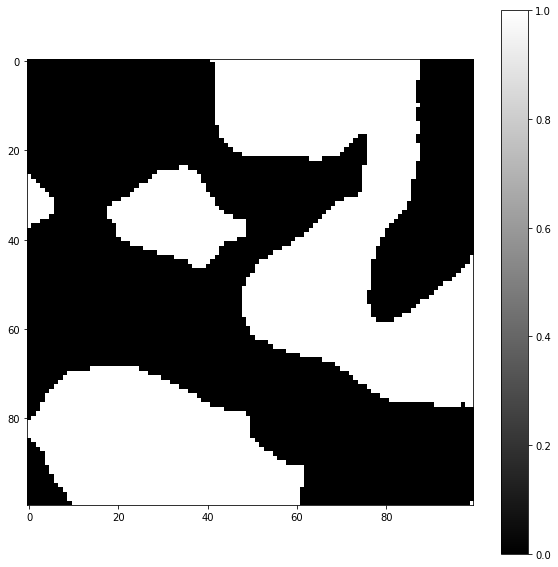

In [156]:
rdp.imm(recon3[1000:1100,1000:1100],(100,100))

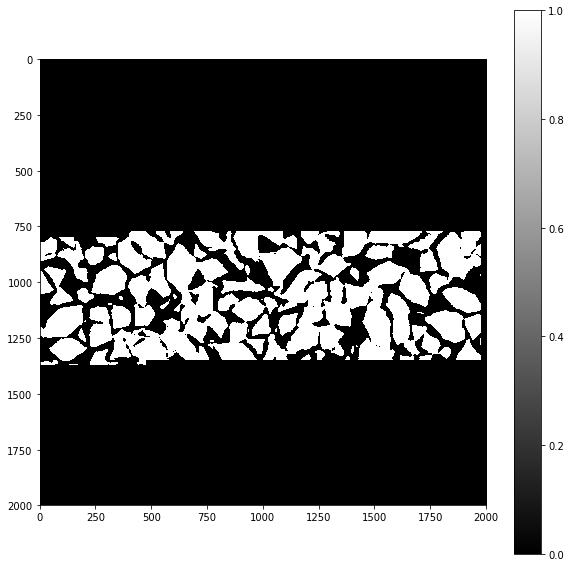

In [157]:
rdp.imm(recon3,(2000,2000))

In [158]:
recon3 = recon3[750:1500,750:1500]

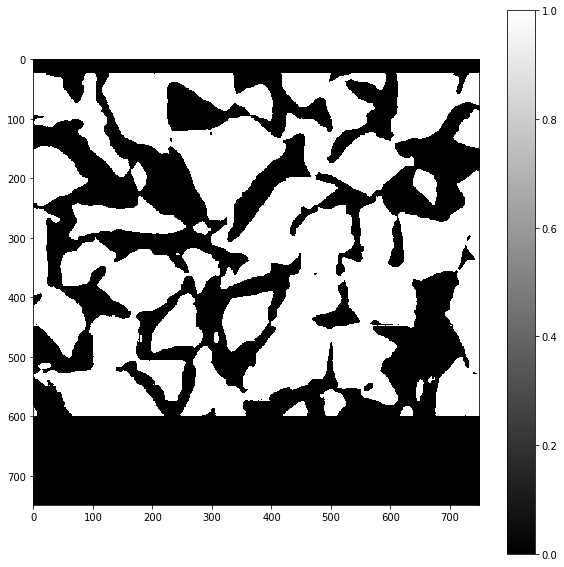

In [160]:
rdp.imm(recon3,(750,750))

In [175]:
recon4 = morph.binary_erosion(morph.binary_erosion(morph.binary_erosion(morph.binary_erosion(recon3,morph.disk(2)),morph.disk(10)),morph.disk(2)),morph.disk(2))

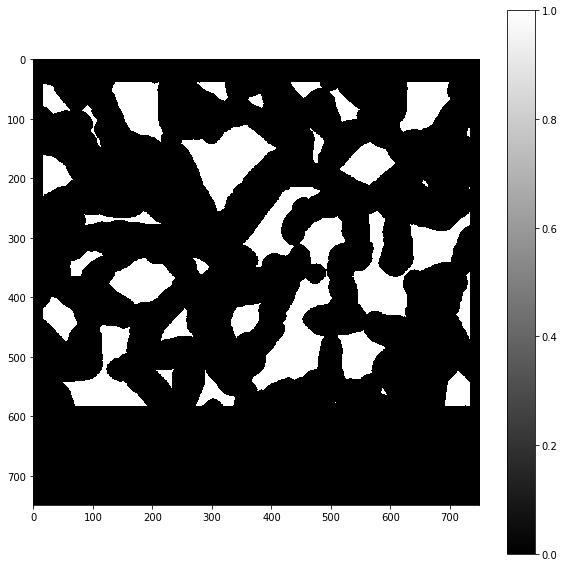

In [176]:
rdp.imm(recon4,(750,750))

In [102]:
def unslide_window(stack,sub_img_indices,total_pixel_X,step,input_type = 'images'):
    """sub_img_indices should be two element tuple indicating which start and end slice image stack represents. 
    currently only implmented for square images that have been sliced up. input type is either 'images' or 'masks'"""
    window_size = stack.shape[1]
    num_windows = (total_pixel_X-window_size)//step
    tuple_index_list = make_tuple_idx(sub_img_indices,(num_windows,num_windows))
    int_maxX = np.array(tuple_index_list)[:,0].max()
    int_maxY = np.array(tuple_index_list)[:,1].max()
    int_minX = np.array(tuple_index_list)[:,0].min()
    int_minY = np.array(tuple_index_list)[:,1].min()
    max_sizeX = int_maxX*step+window_size
    max_sizeY = int_maxY*step+window_size
    min_sizeX = int_minX*step+window_size
    min_sizeY = int_minY*step+window_size
    deltaX = max_sizeX-min_sizeX + 400
    deltaY = max_sizeY-min_sizeY + 400
    print(max_sizeX, max_sizeY, min_sizeX,min_sizeY, deltaX,deltaY)
    if input_type == 'images':
        recon = np.ones((deltaX,deltaY))*-1
    elif input_type == 'masks':
        recon = np.zeros((deltaX,deltaY))
    else:
        RuntimeError('Does not reconize input type. Choose either images or masks')
    for idx, img in enumerate(stack):
        new_indices = tuple_index_list[idx]
        x_idx = (new_indices[0]*step+window_size)-min_sizeX
        y_idx = (new_indices[1]*step+window_size)-min_sizeY
        print(x_idx, y_idx)
        if input_type == 'images':
            recon[x_idx*step:x_idx*step+window_size,y_idx*step:y_idx*step+window_size] = img
        else:
            print(recon[x_idx*step:x_idx*step+window_size,y_idx*step:y_idx*step+window_size].shape)
            recon[x_idx*step:x_idx*step+window_size,y_idx*step:y_idx*step+window_size] += img
    return recon